# The Database Interface Classes

For each API endpoint exposed in the Django app, there is a corresponding class that
provide methods to execute CRUD operations asynchronously.

There are two types of API endpoints -- those that contain only records data, and 
those that store both records and pointers to files.



## Connecting to the Database

The database currently runs on HTCF service partition. This is a single
node with 8 CPU and 30 GB that is meant for long running low resource jobs.
The components that need to run are a postgres database, a redis instance and the
django app. As long as these components are running on the service partition, 
you can connect via an ssh tunnel with:

```bash
ssh username@login.htcf.wustl.edu -N -L 8001:n240:8000
```

where the `8001:n240:8000` takes the form of `local_port:cluster_node:app_port`. The
django app will always be served on port `8000`, and `n240` is the only service
partition node. You may choose a different local port.

If you do this and cannot connect, let me know and I'll check the status of the jobs 
on the cluster.

### Database username and password

Once you have a tunnel, you can access the database frontend at `127.0.0.1:8001`
(or a different local port, if you changed that number). If you haven't already
signed up, you'll need to click the 'sign up' button and follow
the instructions. The e-mail server is not hooked up at the moment, so when it says
"see the e-mail", send a slack message and let me know. I'll give you a link to
complete the sign up process. After that, you can just use the "sign in" button.

For computational tasks, including generating rank response data, celery workers must
be launched on the HTCF general partition. There is currently a script that is meant to
monitor the redis queue and launch/kill these workers automatically, but this
functionality is new and largely untested. You can monitor the workers/tasks if you
create another tunnel with:

```bash
ssh username@login.htcf.wustl.edu -N -L 8002:n240:5555
```
You'd access this dashboard at `127.0.0.1:5555`

The login is currently:

```raw
username: "flower"
password: "daisy"
```
(yes, really -- the security comes from the fact that you need to login with HTCF)

### Configuring the Database Interface Classes

The database classes expect the following environmental variables to be set. 

```raw
BASE_URL='http://127.0.0.1:8001'
TOKEN='<your token>'
BINDING_URL='http://127.0.0.1:8001/api/binding'
BINDINGMANUALQC_URL='http://127.0.0.1:8001/api/bindingmanualqc'
CALLINGCARDSBACKGROUND_URL='http://127.0.0.1:8001/api/callingcardsbackground'
DATASOURCE_URL='http://127.0.0.1:8001/api/datasource'
EXPRESSION_URL='http://127.0.0.1:8001/api/expression'
EXPRESSIONMANUALQC_URL='http://127.0.0.1:8001/api/expressionmanualqc'
FILEFORMAT_URL='http://127.0.0.1:8001/api/fileformat'
GENOMICFEATURE_URL='http://127.0.0.1:8001/api/genomicfeature'
PROMOTERSET_URL='http://127.0.0.1:8001/api/promoterset'
PROMOTERSETSIG_URL='http://127.0.0.1:8001/api/promotersetsig'
REGULATOR_URL='http://127.0.0.1:8001/api/regulator'
```

This can be achieved in the package during development with a `.env` file at the
top most level of the package. The `.env` file is loaded in the package `__init__.py`.

If you are importing `yeastdnnexplorer` into a different environment, then you'll 
need to add the package `dotenv` and execute `load_dotenv(dotenv_path=env_path)`. If
the `.env` file is in the same `PWD` in which you execute that command, there is no
need to specify a path.

### Token Authentication

Once you have a username and password to the database, you can retrieve your token. 
Make sure that you put this token, at least, in a `.env` file, and make sure that 
`.env` file is in your `.gitignore`.

Alternatively, you could retrieve and store in memory the token at the beginning of 
each session -- this is more secure if you are not using a `.env` file.  

The `.env` file is already in the `yeastddnexplorer` `.gitignore`

```bash
curl -X 'POST' \
  'http://127.0.0.1:8001/auth-token/' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{
  "username": "username",
  "password": "password"
}'
```

Or with python:

```python
import requests

url = "http://127.0.0.1:8001/auth-token/"
headers = {
    "accept": "application/json",
    "Content-Type": "application/json",
}
data = {
    "username": "username",
    "password": "password",
}

response = requests.post(url, json=data, headers=headers)
print(response.text)
```

## Using the Interface Classes

In [40]:
from yeastdnnexplorer.interface import *
import matplotlib.pyplot as plt

## Records Only Endpoints

The records only endpoints are:

- BindingManualQC

- DataSource

- ExpressionManualQC

- FileFormat

- GenomicFeature

- PromoterSetSig

- Regulator

When the `read()` method is called on the corresponding API classes, a dataframe will
be returned in the response.

All of the `read()` methods, for both types of API endpoints, return the result of
a callable. By default, the callable returns a dictionary with two keys: `metadata` and
`data`. For response only tables, the `metadata` value will be the records from the
database as a pandas dataframe and the `data` will be `None.

### Example -- RegulatorAPI

In [41]:
regulator = RegulatorAPI()

result = await regulator.read()
result.get("metadata")

,id,uploader_id,upload_date,modifier_id,modified_date,genomicfeature_id,under_development,notes,regulator_locus_tag,regulator_symbol
0,1,2,2024-07-01,2,2024-07-01 17:47:18.619129+00:00,24,False,none,YAL051W,OAF1
1,2,2,2024-07-01,2,2024-07-01 17:47:19.667722+00:00,140,False,none,YBL103C,RTG3
2,3,2,2024-07-01,2,2024-07-01 17:47:20.523161+00:00,186,False,none,YBL066C,SEF1
3,4,2,2024-07-01,2,2024-07-01 17:47:21.309606+00:00,199,False,none,YBL054W,TOD6
4,5,2,2024-07-01,2,2024-07-01 17:47:22.161007+00:00,201,False,none,YBL052C,SAS3
...,...,...,...,...,...,...,...,...,...,...
1809,1810,2,2024-07-01,2,2024-07-01 19:14:36.164403+00:00,6387,False,none,YOR262W,GPN2
1810,1811,2,2024-07-01,2,2024-07-01 19:14:38.921261+00:00,7070,False,none,YPR190C,RPC82
1811,1812,2,2024-07-01,2,2024-07-01 19:15:51.518999+00:00,6603,False,none,YPL228W,CET1
1812,1813,2,2024-07-01,2,2024-07-01 19:15:56.555122+00:00,4083,False,none,YKL049C,CSE4


## Record and File Endpoints

The record and file endpoints are the following:

- CallingCardsBackground

- Expression

- PromoterSet

- PromoterSetSig

- RankResponse *

The default `read()` method is the same as the Records only Endpoint API classes.
However, there is an additional argument, `retrieve_files` which if set to `True`
will retrieve the file for which each record provides metadata. The return value of
`read()` is again a callable, and by default the `data` key will store a dictionary
where the keys correspond to the `id` column in the `metadata`.


In [42]:
# First, retrieve only the records -- you'll want to filter these results down before
# retrieving the files most likely
pss_api = PromoterSetSigAPI()
result = await pss_api.read()
result.get("metadata")

,id,uploader_id,upload_date,modifier_id,modified_date,single_binding_id,composite_binding_id,promoter_id,background_id,fileformat_id,file
0,1,2,2024-07-01,2,2024-07-01 18:51:48.611781+00:00,1.0,NaN,NaN,NaN,1,promotersetsig/1.csv.gz
1,2,2,2024-07-01,2,2024-07-01 18:51:49.643452+00:00,2.0,NaN,NaN,NaN,1,promotersetsig/2.csv.gz
2,3,2,2024-07-01,2,2024-07-01 18:51:50.744384+00:00,3.0,NaN,NaN,NaN,1,promotersetsig/3.csv.gz
3,4,2,2024-07-01,2,2024-07-01 18:51:51.507918+00:00,4.0,NaN,NaN,NaN,1,promotersetsig/4.csv.gz
4,5,2,2024-07-01,2,2024-07-01 18:51:52.277595+00:00,5.0,NaN,NaN,NaN,1,promotersetsig/5.csv.gz
...,...,...,...,...,...,...,...,...,...,...,...
2187,6933,1,2024-07-06,1,2024-07-06 16:08:45.567814+00:00,NaN,67.0,4.0,1.0,5,promotersetsig/6933.csv.gz
2188,6934,1,2024-07-06,1,2024-07-06 16:08:45.921894+00:00,NaN,68.0,4.0,1.0,5,promotersetsig/6934.csv.gz
2189,6935,1,2024-07-06,1,2024-07-06 16:08:46.166036+00:00,NaN,69.0,4.0,1.0,5,promotersetsig/6935.csv.gz
2190,6936,1,2024-07-06,1,2024-07-06 16:08:46.246482+00:00,NaN,70.0,4.0,1.0,5,promotersetsig/6936.csv.gz


## Filtering

All API classes have a `params` attribute which stores the filtering parameters
which will be applied to the HTTP requests.

In [43]:
pss_api.push_params({"regulator_symbol": "GZF3",
                     "workflow": "nf_core_callingcards_1_0_0",
                     "data_usable": "pass"})

In [44]:
pss_api.params

ParamsDict({'regulator_symbol': 'GZF3', 'workflow': 'nf_core_callingcards_1_0_0', 'data_usable': 'pass'})

## Retrieving files from a Records and Files Object

To retrieve files from a Records and Files endpoint object, do the following:

In [45]:
# note that retrieve_files is set to True
result = await pss_api.read(retrieve_files = True)

# the metadata slot is the same as before
result.get("metadata")

,id,uploader_id,upload_date,modifier_id,modified_date,single_binding_id,composite_binding_id,promoter_id,background_id,fileformat_id,file
0,6577,1,2024-07-01,1,2024-07-01 21:43:50.145871+00:00,1837,NaN,4,1,5,promotersetsig/6577.csv.gz
1,6580,1,2024-07-01,1,2024-07-01 21:43:50.968078+00:00,1841,NaN,4,1,5,promotersetsig/6580.csv.gz
2,6642,1,2024-07-01,1,2024-07-01 21:43:54.969507+00:00,1902,NaN,4,1,5,promotersetsig/6642.csv.gz
3,6651,1,2024-07-01,1,2024-07-01 21:43:55.326651+00:00,1911,NaN,4,1,5,promotersetsig/6651.csv.gz
4,6717,1,2024-07-01,1,2024-07-01 21:44:00.500038+00:00,1960,NaN,4,1,5,promotersetsig/6717.csv.gz


In [46]:
# but now the data slot is a dictionary where the `id` are keys and the values
# are the files parsed into pandas dataframes
result.get("data").get("6568")

In [47]:
binding = BindingAPI()

binding.push_params({"regulator_symbol": "GZF3",
                     "workflow": "nf_core_callingcards_1_0_0",
                     "data_usable": "pass"})

binding_res = await binding.read()

binding_res.get("metadata")

,id,uploader_id,upload_date,modifier_id,modified_date,regulator_id,batch,replicate,source_id,source_orig_id,strain,condition,file,genomic_inserts,mito_inserts,plasmid_inserts,notes
0,1960,2,2024-07-01,2,2024-07-01 19:26:32.883701+00:00,135,run_6140,1,1,96,unknown,unknown,binding/brent_nf_cc/1960.qbed.gz,6741,4,0,source_orig_id is ccexperiment id from current...
1,1911,2,2024-07-01,2,2024-07-01 19:25:49.763432+00:00,135,run_6421,1,1,129,unknown,unknown,binding/brent_nf_cc/1911.qbed.gz,11268,0,0,source_orig_id is ccexperiment id from current...
2,1902,2,2024-07-01,2,2024-07-01 19:25:42.539520+00:00,135,run_6374,1,1,118,unknown,unknown,binding/brent_nf_cc/1902.qbed.gz,6033,0,0,source_orig_id is ccexperiment id from current...
3,1841,2,2024-07-01,2,2024-07-01 19:24:51.708289+00:00,135,run_6106,1,1,85,unknown,unknown,binding/brent_nf_cc/1841.qbed.gz,7025,19,0,source_orig_id is ccexperiment id from current...
4,1837,2,2024-07-01,2,2024-07-01 19:24:48.660145+00:00,135,run_6100,1,1,80,unknown,unknown,binding/brent_nf_cc/1837.qbed.gz,7328,13,0,source_orig_id is ccexperiment id from current...


Parameters can be removed one by one

In [48]:
print(pss_api.params)

regulator_symbol: GZF3, workflow: nf_core_callingcards_1_0_0, data_usable: pass


In [49]:
pss_api.pop_params('data_usable')

print(pss_api.params)

regulator_symbol: GZF3, workflow: nf_core_callingcards_1_0_0


or cleared entirely

In [50]:
pss_api.pop_params(None)

print(pss_api.params)

True

## Another example with Expression

This is used to get an expression_id to use in the RankResponseAPI() below

In [51]:
expression = ExpressionAPI()

expression.push_params({"regulator_symbol": "GZF3",
                        "lab": "mcisaac",
                        "time": "15"})

expression_res = await expression.read()

expression_res.get("metadata")

,id,uploader_id,upload_date,modifier_id,modified_date,regulator_id,batch,strain,replicate,control,mechanism,restriction,time,source_id,file,notes
0,2516,2,2024-07-01,2,2024-07-01 18:36:13.814201+00:00,135,undefined,SMY156n,1,undefined,gev,N,15.0,7,expression/mcisaac_oe/2516.csv.gz,strain_id:SMY156n ; date:20150101
1,2510,2,2024-07-01,2,2024-07-01 18:36:08.810276+00:00,135,undefined,SMY156,1,undefined,gev,P,15.0,7,expression/mcisaac_oe/2510.csv.gz,strain_id:SMY156 ; date:20150101


## Rank Response

The rank response endpoint is slightly different than the others.

1. It is an additional action of the promotersetsig table, and so does not have
   a 'records_only' option. Data files will always be retrieved/returned.

1. It currently requires that the parameters `promotersetsig_id` and `expression_id`
   be set.

1. It requires that celery workers are available. On the cluster, this means
    submitting additional jobs. At the time of writing, this hasn't yet been automated.

1. The `id` is the concatenation of the `promotersetsig_id`_`expression_id`

In [52]:
rr_api = RankResponseAPI()

rr_api.push_params({"promotersetsig_id": "6577",
                    "expression_id": "2510"})

result = await rr_api.read()

In [53]:
result.get("metadata")

,id,promotersetsig_id,n_responsive,total_expression_genes,filename,expression_id
0,6577_2510,6577,810,6175,6577_2510.csv.gz,2510


In [54]:
result.get("data").get(result.get("metadata").id[0])

,rank_bin,n_responsive_in_rank,random,n_successes,response_ratio,pvalue,ci_lower,ci_upper
0,5,4,0.131036,4,0.800000,1.319573e-03,0.283582,0.994949
1,10,3,0.131036,7,0.700000,5.528300e-05,0.347547,0.933260
2,15,3,0.131036,10,0.666667,2.380664e-06,0.383804,0.881759
3,20,4,0.131036,14,0.700000,7.807053e-09,0.457211,0.881068
4,25,3,0.131036,17,0.680000,3.727753e-10,0.464999,0.850505
...,...,...,...,...,...,...,...,...
1226,6135,2,0.131036,804,0.131051,1.000000e+00,0.122703,0.139753
1227,6140,1,0.131036,805,0.131107,9.849126e-01,0.122760,0.139807
1228,6145,0,0.131036,805,0.131001,1.000000e+00,0.122660,0.139693
1229,6150,1,0.131036,806,0.131057,1.000000e+00,0.122718,0.139747


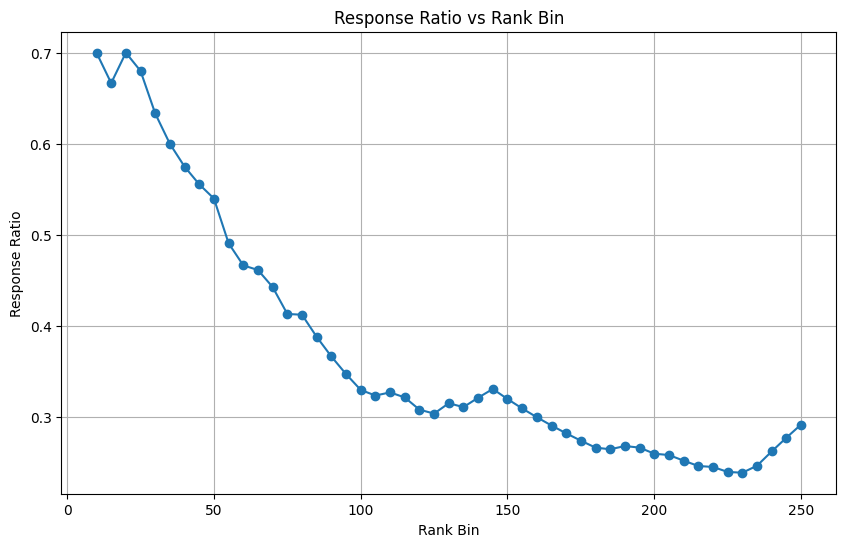

In [55]:
df = result.get("data").get(result.get("metadata").id[0]).iloc[1:50,:]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df['rank_bin'], df['response_ratio'], marker='o')
plt.title('GZF3 - promotersetsig_id 6577. McIsaac 15 2510')
plt.xlabel('Rank Bin')
plt.ylabel('Response Ratio')
plt.title('Response Ratio vs Rank Bin')
plt.grid(True)
plt.show()

# CallingCards Aggregated Data

For regulators which have data generated in the Brentlab and processed through the
nf-core/callingcards:1.0.0 workflow, if that data has been manually (or eventually 
automatically) QC reviewed,
*and if there are at least 2 samples which are labeled as data_usable*, then there will
exist a BindingConcatenated record to which both a BindingManualQC record *and* a
PromoterSetSig record are foreign keyed.

To view the set of samples for which there is aggregated data, you may do the following:

In [65]:
pss_api.pop_params(None)

pss_api.push_params({"datasource": "brent_nf_cc", "aggregated": "true"})

callingcards_aggregated_meta_res = await pss_api.read()

callingcards_aggregated_meta_df = callingcards_aggregated_meta_res.get("metadata")

In [66]:
callingcards_aggregated_meta_df

,id,uploader_id,upload_date,modifier_id,modified_date,single_binding_id,composite_binding_id,promoter_id,background_id,fileformat_id,file
0,6867,1,2024-07-06,1,2024-07-06 16:08:33.125644+00:00,NaN,6,4,1,5,promotersetsig/6867.csv.gz
1,6868,1,2024-07-06,1,2024-07-06 16:08:33.125640+00:00,NaN,3,4,1,5,promotersetsig/6868.csv.gz
2,6869,1,2024-07-06,1,2024-07-06 16:08:33.119818+00:00,NaN,1,4,1,5,promotersetsig/6869.csv.gz
3,6870,1,2024-07-06,1,2024-07-06 16:08:33.125605+00:00,NaN,5,4,1,5,promotersetsig/6870.csv.gz
4,6871,1,2024-07-06,1,2024-07-06 16:08:33.129564+00:00,NaN,4,4,1,5,promotersetsig/6871.csv.gz
...,...,...,...,...,...,...,...,...,...,...,...
66,6933,1,2024-07-06,1,2024-07-06 16:08:45.567814+00:00,NaN,67,4,1,5,promotersetsig/6933.csv.gz
67,6934,1,2024-07-06,1,2024-07-06 16:08:45.921894+00:00,NaN,68,4,1,5,promotersetsig/6934.csv.gz
68,6935,1,2024-07-06,1,2024-07-06 16:08:46.166036+00:00,NaN,69,4,1,5,promotersetsig/6935.csv.gz
69,6936,1,2024-07-06,1,2024-07-06 16:08:46.246482+00:00,NaN,70,4,1,5,promotersetsig/6936.csv.gz


In [67]:
pss_api.push_params({"regulator_symbol": "GZF3"})

callingcards_res = await pss_api.read()

gzf3_callingcards_res = callingcards_res.get("metadata")

gzf3_callingcards_res

#gzf3_callingcards_res[~gzf3_callingcards_res.composite_binding_id.isna()]

,id,uploader_id,upload_date,modifier_id,modified_date,single_binding_id,composite_binding_id,promoter_id,background_id,fileformat_id,file
0,6873,1,2024-07-06,1,2024-07-06 16:08:33.117009+00:00,NaN,7,4,1,5,promotersetsig/6873.csv.gz


In [74]:
rr_api.pop_params(None)

rr_api.push_params({"promotersetsig_id": "6873",
                    "expression_id": "2510"})

agg_result = await rr_api.read()

agg_result


{'metadata':           id promotersetsig_id  n_responsive  total_expression_genes  \
 0  6873_2510              6873           810                    6175   
 
            filename expression_id  
 0  6873_2510.csv.gz          2510  ,
 'data': {'6873_2510':       rank_bin  n_responsive_in_rank    random  n_successes  response_ratio  \
  0            5                     4  0.131036            4        0.800000   
  1           10                     3  0.131036            7        0.700000   
  2           15                     4  0.131036           11        0.733333   
  3           20                     3  0.131036           14        0.700000   
  4           25                     5  0.131036           19        0.760000   
  ...        ...                   ...       ...          ...             ...   
  1226      6135                     2  0.131036          804        0.131051   
  1227      6140                     1  0.131036          805        0.131107   
  1228      614

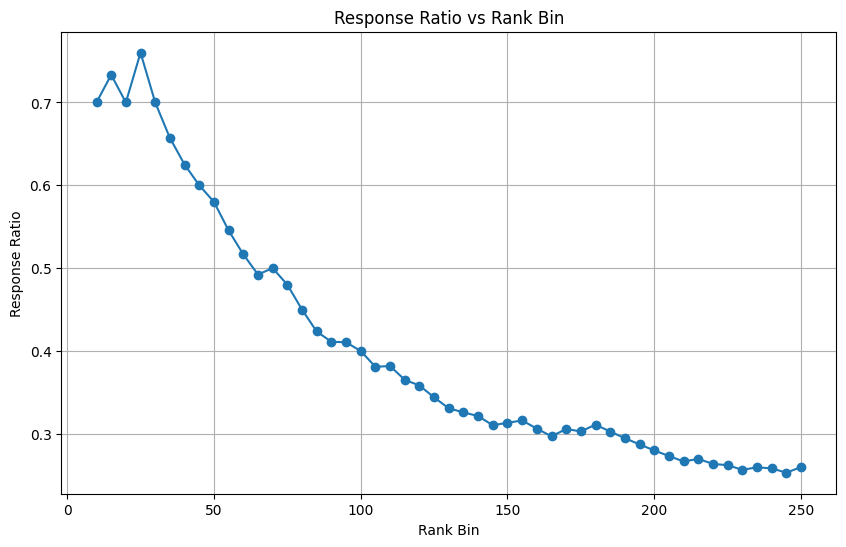

In [76]:
agg_df = agg_result.get("data").get(agg_result.get("metadata").id[0]).iloc[1:50,:]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(agg_df['rank_bin'], agg_df['response_ratio'], marker='o')
plt.title('Aggregated GZF3. McIsaac 15 2510')
plt.xlabel('Rank Bin')
plt.ylabel('Response Ratio')
plt.title('Response Ratio vs Rank Bin')
plt.grid(True)
plt.show()

## Caveats

1. I have written the scripts to automatically check the redis queue for work and to 
   both launch celery worker nodes, and kill them when they are finished. But, though
   they work if I run them manually, they have not worked when scheduled through a
   cronjob. I'll work with Brian and Eric next week to figure out why.

1. I haven't tested each of the endpoint APIs individually. Help is welcome.